<a href="https://colab.research.google.com/github/gtimokhina/Deep-Learning/blob/master/MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MNIST classifier using only numpy, python and plain neural networks.

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from matplotlib import pyplot 
np.random.seed(1)

Using TensorFlow backend.


####Import MNIST dataset

In [0]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

####Show few samples images from dataset

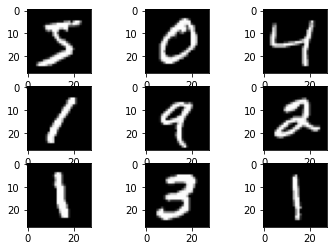

In [3]:
from matplotlib import pyplot 
for i in range(0, 9):  
    pyplot.subplot(330 + 1 + i)  
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray')) 
pyplot.show()

####Basic image augmentations using keras

In [0]:
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip = False)  # randomly flip images


####Add 1,000 augmented images to our train dataset

In [5]:
# reshape the images
x_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
datagen.fit(x_train)
augment_size=1000
# get transformed images
randidx = np.random.randint(len(x_train), size=augment_size)
x_augmented = x_train[randidx].copy()
y_augmented = y_train[randidx].copy()
x_augmented = datagen.flow(x_augmented, np.zeros(augment_size),batch_size=augment_size, shuffle=False).next()[0]
# append augmented data to trainset
X_train = np.concatenate((x_train, x_augmented))
y_train = np.concatenate((y_train, y_augmented))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (60000, 1, 28, 28) (28 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1000, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


####Check some augmented images

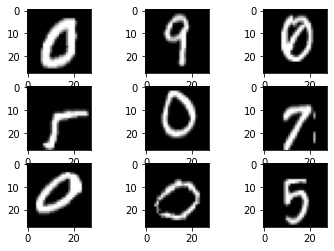

In [6]:
for i in range(0, 9):  
    pyplot.subplot(330 + 1 + i)  
    pyplot.imshow(x_augmented[i].reshape(28, 28), cmap=pyplot.get_cmap('gray')) 
pyplot.show()

####Reshape and normalize data to range 0-1 

In [0]:
train_images, train_labels = (X_train.reshape(len(X_train), 28*28) / 255, y_train)
test_images = X_test.reshape(len(X_test), 28*28) / 255

####Prepare test and train labels by transforming the integer into a 10 element array with a 1 for the index of the class value, and 0 values for all other classes.

In [0]:
# train labels
temp_labels = np.zeros((len(train_labels),10))
for i,j in enumerate(train_labels):
    temp_labels[i][j] = 1
train_labels = temp_labels

# test labels
test_labels = np.zeros((len(y_test),10))
for i,j in enumerate(y_test):
    test_labels[i][j] = 1

####Define RELU activation function for hidden layers

In [0]:
def relu(x):
    return (x > 0) * x 

####Define RELU derivative

In [0]:
def relu_derivative(x):
    return  (x > 0)  

####Define SOFTMAX activation function for the output layer

In [0]:
def softmax(x):
    temp = np.exp(x)
    return temp / np.sum(temp, axis=1, keepdims = True)

####Define learning rate as 2, the first hidden layer size as 100, the second hidden layer size as 64
Number of pixels as 784, number of labels as 10

In [0]:
alpha, hidden_size_1, hidden_size_2 = (2, 100, 64)
pixels_image, num_of_labels = (784, 10)

####Define batch size as 100 for mini batch gradient descent

In [0]:
batch_size = 100

####Initialize weights randomly using formula w = np.random.randn(n) * sqrt(2.0/n)

In [0]:
weight_0_1 = np.random.randn(pixels_image,hidden_size_1) * np.sqrt(2.0/pixels_image)
weight_1_2 = np.random.randn(hidden_size_1,hidden_size_2) * np.sqrt(2.0/hidden_size_1)
weight_2_3 = np.random.randn(hidden_size_2,num_of_labels) * np.sqrt(2.0/hidden_size_2)

####Training and results. Do 200 iterations, print only every 10th iteration results. I did not see much improvements after 200 iterations

In [15]:
iterations = 200
for j in range(iterations):
    train_correct_count = 0
    # do mini batches
    for i in range(int(len(train_images) / batch_size)):
        batch_start, batch_end = ((i * batch_size), ((i + 1) * batch_size))

        ### FORWARD PROPAGATION
        layer_0 = train_images[batch_start:batch_end]
   
        # hidden layer 1
        layer_1 = relu(np.dot(layer_0,weight_0_1))
        # apply dropout rate for layer 1 as 50%
        dropout_mask_1 = np.random.randint(2, size = layer_1.shape)
        layer_1 *= dropout_mask_1 * 2
        
        # hidden layer 2
        layer_2 = relu(np.dot(layer_1,weight_1_2))
        # apply dropout rate for layer 2 as 20%
        dropout_mask_2 = np.random.binomial(1, 0.2, size=layer_2.shape) / 0.2 
        layer_2 *= dropout_mask_2 
        
        # last ouput layer
        layer_3 = softmax(np.dot(layer_2,weight_2_3))
        
        # calulate correct answers
        for k in range(batch_size):
            train_correct_count += int(np.argmax(layer_3[k:k+1]) == np.argmax(train_labels[batch_start+k:batch_start+k+1]))
            
        ### BACKPROPAGATION
        # calculate each layer delta
        layer_3_delta = (layer_3 - train_labels[batch_start:batch_end]) / (batch_size * layer_3.shape[0])
        layer_2_delta = np.dot(layer_3_delta,weight_2_3.T) * relu_derivative(layer_2)
        layer_2_delta *= dropout_mask_2
        layer_1_delta = np.dot(layer_2_delta,weight_1_2.T) * relu_derivative(layer_1)
        layer_1_delta *= dropout_mask_1
        
        # recalculate weights
        weight_2_3 -= alpha * layer_2.T.dot(layer_3_delta)
        weight_1_2 -= alpha * layer_1.T.dot(layer_2_delta)
        weight_0_1 -= alpha * layer_0.T.dot(layer_1_delta)
              
    # test results
    test_correct_count = 0
    test_predictions = [] 
    for i in range(len(test_images)):
        layer_0 = test_images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weight_0_1))
        layer_2 = np.dot(layer_1, weight_1_2)
        layer_3 = np.dot(layer_2, weight_2_3)
        
        test_correct_count += int(np.argmax(layer_3) == np.argmax(test_labels[i:i+1]))
        test_predictions.append(np.argmax(layer_3))
        
    # print only every 10th result
    if (j % 10 == 0):
        print("\n"+ "Iteration:" + str(j) + \
         "; Test Accuracy:" + str(test_correct_count/float(len(test_images))) + \
         "; Train Accuracy:" + str(train_correct_count/float(len(train_images))))
        print('Confusion Matrix: \n', confusion_matrix(y_test,test_predictions))
        print('Classification metrics: \n', classification_report(y_test,test_predictions))


Iteration:0; Test Accuracy:0.7478; Train Accuracy:0.25881967213114754
Confusion Matrix: 
 [[ 923    0    2    6    0   20   15    5    0    9]
 [   0 1124    2    1    0    2    5    1    0    0]
 [  34  107  740   36   12    1   39   45    5   13]
 [   7   60   24  834    1   23    5   36    5   15]
 [   3   14    3    1  518    0   25    6    4  408]
 [  44   34   14  167   20  494   46   22    9   42]
 [  30    8   71    0    4   22  818    3    0    2]
 [   5   50   12    2    3    0    0  926    0   30]
 [  24  187   15  177   30   95   30   28  293   95]
 [  20   20    4   11   41    5    4   95    1  808]]
Classification metrics: 
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       980
           1       0.70      0.99      0.82      1135
           2       0.83      0.72      0.77      1032
           3       0.68      0.83      0.74      1010
           4       0.82      0.53      0.64       982
           5       0.75    